# Responsible AI using SciPy
### PyData Virginia Tutorial – Andrea Hobby
#### Goal: Using SciPy for a sensitivity analysis - This is to see which features influence the model the most. 

## Tutorial Overview

We will be exploring bias detection and mitigiation with Chronic Kidney Disease data. 

Chronic kidney disease (CKD) is when the kidneys are damaged and cannot correctly filter waste and excess fluids from the blood. About 37 million people in the United States have Chronic Kidney Disease (CKD). Early detection and diagnosis of CKD are essential to preventing its progression to kidney failure. Machine learning models can assist in predicting CKD. There are variables such as age, gender, medical history, and laboratory test results in this dataset. The data is from the National Health and Nutrition Examination Surveys. This data was chosen because chronic kidney disease is a condition that commonly has health disparities. 


##  1. Load Data and Model

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import sobol_indices
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score



ImportError: cannot import name 'sobol_indices' from 'scipy.stats' (/Users/apple/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/__init__.py)

In [ ]:
# # change the current directory
# # to specified directory
# os.chdir("/Users/andre/Documents/DataScienceProjects/PyData")

# Read in datasets from my directory
df = pd.read_csv('casedata.csv')

In [ ]:
# Drop irrelevant or redudant columns 
df_drop = df.drop(['ID', 'Weight', 'Height', 'Obese', 'Waist'], axis=1)

# Drop irrelevant or redudant columns 
df_drop = df.drop(['ID', 'Weight', 'Height', 'Obese', 'Waist'], axis=1)
# Define the age bins
bins = [18, 35, 50, 65, 85]

# Define the bin labels
labels = ['18-34', '35-49', '50-64', '65 and older']

# Convert the age variable into a categorical variable
df_drop['age_group'] = pd.cut(df_drop['Age'], bins=bins, labels=labels)

# View the resulting DataFrame
print(df_drop)

bins = [0, 25, 30, 100]

# Define the bin labels
labels = ['Normal', 'Overweight', 'Obese']

# Convert the BMI variable into a categorical variable
df_drop['BMI_group'] = pd.cut(df_drop['BMI'], bins=bins, labels=labels)

# View the resulting DataFrame
print(df_drop)

# one hot encoding 
# Identify categorical variables
# Select categorical variables
cat_vars = df_drop.select_dtypes(include=['object']).columns.tolist()

# Print the list of categorical variables
print(cat_vars)

# Apply one-hot encoding to categorical variables
df_dummies = pd.get_dummies(df_drop, columns=cat_vars)
print(df_dummies)

uint82flt = df_dummies.select_dtypes(include=['uint8']).columns.tolist()

def convert_to_float(df, column_list):
    for col in column_list:
        df[col] = df[col].astype('float64')
    return df

new_df = convert_to_float(df_dummies, uint82flt)

def convert_to_float64(df, column_names):
    for column_name in column_names:
        df[column_name + '_flt'] = df[column_name].astype('category').cat.codes.astype('float64')
    return df

#category columns

new_df = convert_to_float64(new_df, ['age_group', 'BMI_group'])
new_df.info()

# Drop variables that have categories 
new_array = new_df.drop(['Age', 'BMI', 'age_group', 'BMI_group'], axis=1)

# Drop rows with NaN in the target column
#missing target variable can cause errors during model training 
#because scikit-learn assumes that the target variable is complete and does not contain any missing values.

ckdarray = new_array.dropna(inplace=True)

def split_data(new_array):
    X = new_array.drop(['CKD'], axis=1)
    y = new_array['CKD']
    return X, y

X, y = split_data(new_array)

# print(X)
# print(y)


# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


      Age  Female Racegrp  Educ  Unmarried  Income CareSource  Insured    BMI  \
0      65       1   white   0.0        0.0     1.0      other      1.0  21.31   
1      36       1   hispa   0.0        NaN     1.0    noplace      0.0  22.88   
2      66       1   white   0.0        1.0     0.0    noplace      1.0  31.77   
3      54       1   white   1.0        0.0     0.0      DrHMO      1.0  26.94   
4      63       1   black   0.0        0.0     NaN     clinic      1.0  28.84   
...   ...     ...     ...   ...        ...     ...        ...      ...    ...   
8814   32       1   white   1.0        0.0     1.0      DrHMO      1.0  28.28   
8815   77       1   white   0.0        1.0     0.0     clinic      1.0  26.70   
8816   56       1   white   0.0        0.0     NaN      DrHMO      1.0  18.62   
8817   25       1   black   0.0        1.0     NaN     clinic      0.0  33.52   
8818   60       0   black   0.0        1.0     0.0    noplace      1.0  26.44   

        SBP  ...  Fam Hyper

In [ ]:
# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predictions and accuracy
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")


# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

#MAE close to 0 is ideal to minimize errors



Accuracy: 0.94
Mean Absolute Error (MAE): 0.06


In [ ]:
feature_names = X.columns.tolist()          # X came from the split_data() step
d = len(feature_names)                      # number of inputs

In [ ]:
# 2. Checks probability of being in class 1
def rf_proba(x: np.ndarray) -> np.ndarray:
    # scikit‑learn expects (n, d), so transpose
    p = model.predict_proba(x.T)[:, 1]          # (n,)
    return p.reshape(1, -1)                     # (1, n)

d = X_train.shape[1]  # number of features

In [ ]:
# ## 3 · Wrap the Model as a Callable for `sobol_indices`
# `sobol_indices` expects a function `f(x)` with shape `(d, n) → (1, n)`,
# where `d` = number of inputs and `n` = sample count.
# Sobol index is used in sensitivity analysis to determine 
# how much each input variable (or group of variables) contributes to the 
# uncertainty in the output of a model

def model_fn(x: np.ndarray) -> np.ndarray:
    """
    x.shape = (d, n)  →  returns shape = (1, n)
    Uses predicted probability of CKD = 1 as the output to analyse.
    """
    # a) transpose to (n, d)
    x_df = pd.DataFrame(x.T, columns=feature_names)

    # b) predict probability of the positive class
    p_ckd = model.predict_proba(x_df)[:, 1]   # shape (n,)

    # c) reshape to (1, n) as required by sobol_indices
    return p_ckd.reshape(1, -1)



In [ ]:
# ## 4 · Define Input Distributions
# For demonstration we assume *independe                                                                                  nt* uniform priors spanning the
# min‑to‑max range of each standardized feature  

X_num = X.copy()

bool_cols = X_num.select_dtypes(bool).columns
X_num[bool_cols] = X_num[bool_cols].astype(float)   # True→1.0, False→0.0

dists = [
    stats.uniform(loc=X_num[col].min(),
                  scale=X_num[col].max() - X_num[col].min())
    for col in feature_names
]



In [ ]:
# ## 5 · Run Sobol’ Sensitivity Analysis

n_samples = 1024
sobol_res = stats.sobol_indices(
    func=model_fn, n=n_samples, dists=dists, random_state=42
)   

first = pd.Series(
    sobol_res.first_order.ravel(), index=X.columns, name="First‑order S₁"
)
total = pd.Series(
    sobol_res.total_order.ravel(), index=X.columns, name="Total Sᵀ"
)
pd.concat([first, total], axis=1).sort_values("Total Sᵀ", ascending=False)




AttributeError: module 'scipy.stats' has no attribute 'sobol_indices'

## Interpretation

 High Sᵀ (e.g., Hypertension)  
   → Small errors in these inputs cause large swings in whether a patient is likely to have CKD. 
   

Gap between S₁ and Sᵀ 
   → Indicates interaction effects. If Sᵀ ≫ S₁, the feature’s
   importance comes mainly through interactions with others.

Low indices  
   → Inputs that barely influence the model—candidates for dimensionality
   reduction or de‑prioritized data‑quality efforts.


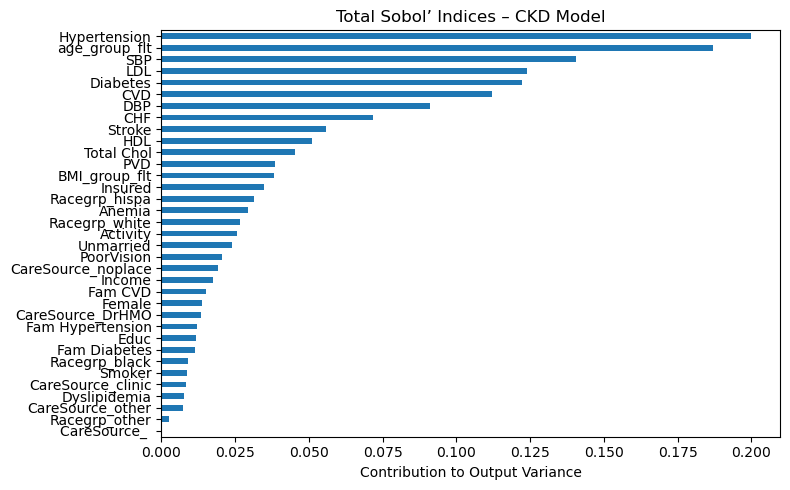

In [ ]:
## Visualize the Results

# %%
fig, ax = plt.subplots(figsize=(8, 5))
total.sort_values().plot.barh(ax=ax)
ax.set_title("Total Sobol’ Indices – CKD Model")
ax.set_xlabel("Contribution to Output Variance")
fig.tight_layout()

## References

Hobby, A. (2023). Predicting Chronic Kidney Disease-Resample [https://github.com/AndreaHobby/CKD-Prediction/blob/main/Predicting%20Chronic%20Kidney%20Disease-Resample.ipynb]
